In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict
import joblib
import utils.models as model_utils

# Preparation

In [4]:
MODEL_FILEDIR = '/scratch/data/TrojAI/rl-lavaworld-jul2023-train/models/'
# MODEL_NUM = 117
MODEL_SUMMARY_FILEPATH = '/scratch/data/TrojAI/rl-lavaworld-jul2023-train/METADATA.csv'
# OUTPUT_FILEDIR = '/scratch/jialin/rl-lavaworld-jul2023-train/weight_analysis/extracted_source/'
METADATA = pd.read_csv(MODEL_SUMMARY_FILEPATH)

def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

def load_model(model_num):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    # model_info_fp = model_filepath + '.stats.json'
    model = torch.load(model_filepath)
    # with open(model_info_fp, 'r') as f:
    #     model_info = json.load(f)
    return model

In [7]:
METADATA['poisoned'] = METADATA['ground_truth'] == 'triggered'

In [8]:
METADATA.head()

,model_name,arch,poison,K1,ground_truth,clean_success,poison_success,poisoned
0,id-00000000,BasicFCModel,NaN,NaN,clean,0.96,NaN,False
1,id-00000001,BasicFCModel,NaN,NaN,clean,0.98,NaN,False
2,id-00000002,BasicFCModel,NaN,NaN,clean,0.98,NaN,False
3,id-00000003,BasicFCModel,NaN,NaN,clean,0.94,NaN,False
4,id-00000004,BasicFCModel,NaN,NaN,clean,0.98,NaN,False


In [11]:
METADATA.shape

(238, 8)

### Feature Extraction

In [90]:
def _get_weight_features(model_repr, axis=None):
    weight_features = []
    for param in model_repr.values():
        pshape = len(param.shape)
        axis = tuple(range(-1, -1*(pshape), -1))
        weight_features += np.max(param, axis= axis).tolist()
        weight_features += np.mean(param, axis= axis).tolist()
        sub = np.mean(param, axis= axis) - np.median(param, axis= axis)
        weight_features += sub.tolist()
        weight_features += np.median(param, axis= axis).tolist()
        weight_features += np.sum(np.abs(param), axis= axis).tolist()
    return weight_features

def _get_eigen_features(model_repr):
    min_shape, params = 1, []
    for param in model_repr.values():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            _, singular_values, _ = np.linalg.svd(reshaped_param, False)
            ssv = np.square(singular_values).flatten()
            params.append(ssv.max().tolist())
            params.append(ssv.mean().tolist())
            params.append((ssv.mean() - np.median(ssv)).tolist())
            params.append(np.median(ssv).tolist())
            params.append(ssv.sum().tolist())
            # params.extend(ssv.flatten().tolist())
    return params

In [91]:
model_id = num_to_model_id(20)
model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
model, model_repr, model_class = model_utils.load_model(model_filepath)

In [92]:
# X, y = [], []
X, y, X_len = {}, {}, {}
for model_num in tqdm(range(238)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model, model_repr, model_class = model_utils.load_model(model_filepath)

    feature = []
    feature += _get_weight_features(model_repr)
    feature += _get_eigen_features(model_repr)
    # fe, fe_len = _get_weight_features(model_backbone, target_layers=target_weight_layers, normalize=False)
    # feature += fe
    # if model_arch not in X_len:
    #     X_len[model_arch] = eig_len

    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()

    if model_class in X:
        X[model_class].append(feature)
        y[model_class].append(poisoned)
        # X_len[model_class] = fe_len
    else:
        X[model_class] = [feature]
        y[model_class] = [poisoned]
        # X_len[model_class] = fe_len

    # X.append(feature)
    # y.append(poisoned)

    del model

  9%|▉         | 21/238 [00:34<05:57,  1.65s/it]


KeyboardInterrupt: 

In [95]:
len(X['SimplifiedRLStarter'][0])

4088

SSD: (cen array([31,  3, 32, 37, 39, 29, 14,  0, 22, 35]), acc array([31, 37,  3, 42, 25, 39, 32, 45, 29, 19]))
DETR: (array([ 80,  55, 134,  52, 285, 321, 267, 320, 299, 305]), array([ 80,  55,  46,  52, 113, 320, 305, 134, 290, 215]))
RCNN: (array([147,  12,  18, 164, 161, 169, 114,  72,  45,  53]), array([164, 169, 161, 147,  12,  18, 114, 127, 137, 140]))

In [12]:
for k, v in X.items():
    np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_X.npy'), v)
    np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_y.npy'), y[k])
    # np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_X_len.npy'), X_len[k])
    print(k, len(v[0]))

SSD 2095
DetrForObjectDetection 966
FasterRCNN 1265


In [22]:
X_len = {}
for model_num in tqdm([0, 1, 3]):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model, _, model_class = model_utils.load_model(model_filepath)
    model = model.to(device)
    if 'Detr' not in model_class:
        model_backbone = model.backbone
    else:
        model_backbone = model

    fe_len, idx_list = [], [(0, 1e8)]
    # if 'SSD' in model_class:
        # idx_list = [(2, 5)]
    # elif 'RCNN' in model_class:
        # idx_list = [(2, 3)]
    # else:
        # idx_list = [(45, 45), (69, 69), (79, 79), (89, 89)]
            
    for idx_lo, idx_hi in idx_list:
        fe_len = _get_eigen_vals(model_backbone, idx_lo, idx_hi)[1]
    X_len[model_class] = fe_len

100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


In [30]:
key = 'FasterRCNN'

In [31]:
weight_range = [0] + X_len[key]
# weight_range = list(range(0, len(X[key][0])+1, 8))

In [32]:
cens, accs = [], []
clf = GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=3, max_features= 120, min_samples_leaf= 6, min_samples_split= 24)

In [33]:
for e_range in tqdm(range(len(weight_range)-1)):
    s, e = e_range, e_range+1
    eigen_len_range = [weight_range[s], weight_range[e]]
    cen, acc = bootstrap_performance(np.asarray(X[key])[:, eigen_len_range[0]:eigen_len_range[1]], np.asarray(y[key]), clf, n=50)
    cens.append(cen)
    accs.append(acc)
    print(f'avg cen for eigen layer {s} is {np.mean(cen)}, avg acc is {np.mean(acc)}')

  0%|          | 1/209 [00:17<59:04, 17.04s/it]

avg cen for eigen layer 0 is 1.0643932470509363, avg acc is 0.5422222222222223


  1%|          | 2/209 [00:33<58:21, 16.92s/it]

avg cen for eigen layer 1 is 0.8261505305147052, avg acc is 0.6488888888888888


  1%|▏         | 3/209 [00:50<57:46, 16.83s/it]

avg cen for eigen layer 2 is 0.8101378250768598, avg acc is 0.6111111111111112


  2%|▏         | 4/209 [01:07<57:47, 16.91s/it]

avg cen for eigen layer 3 is 0.8477452250933064, avg acc is 0.6088888888888889


  2%|▏         | 5/209 [01:24<57:29, 16.91s/it]

avg cen for eigen layer 4 is 0.7140559537284339, avg acc is 0.7222222222222223


  3%|▎         | 6/209 [01:41<56:42, 16.76s/it]

avg cen for eigen layer 5 is 0.9111582368853527, avg acc is 0.64


  3%|▎         | 7/209 [02:09<1:09:51, 20.75s/it]

avg cen for eigen layer 6 is 0.7680052767354764, avg acc is 0.7266666666666667


  4%|▍         | 8/209 [02:26<1:05:24, 19.52s/it]

avg cen for eigen layer 7 is 0.7971670468091426, avg acc is 0.7244444444444444


  4%|▍         | 9/209 [02:43<1:02:00, 18.60s/it]

avg cen for eigen layer 8 is 0.9072668762831558, avg acc is 0.548888888888889


  5%|▍         | 10/209 [03:00<59:47, 18.03s/it] 

avg cen for eigen layer 9 is 0.9793798518176752, avg acc is 0.62


  5%|▌         | 11/209 [03:17<58:24, 17.70s/it]

avg cen for eigen layer 10 is 0.786173548526897, avg acc is 0.6733333333333331


  6%|▌         | 12/209 [03:33<56:55, 17.34s/it]

avg cen for eigen layer 11 is 0.8512596975268879, avg acc is 0.6155555555555555


  6%|▌         | 13/209 [03:50<55:58, 17.13s/it]

avg cen for eigen layer 12 is 0.8405860060824725, avg acc is 0.7177777777777777


  7%|▋         | 14/209 [04:07<55:23, 17.05s/it]

avg cen for eigen layer 13 is 0.9286750068781099, avg acc is 0.6333333333333333


  7%|▋         | 15/209 [04:23<54:33, 16.87s/it]

avg cen for eigen layer 14 is 0.8545813527882641, avg acc is 0.6155555555555555


  8%|▊         | 16/209 [04:40<54:16, 16.87s/it]

avg cen for eigen layer 15 is 0.9162016573364875, avg acc is 0.6755555555555556


  8%|▊         | 17/209 [04:57<54:14, 16.95s/it]

avg cen for eigen layer 16 is 0.722066505746896, avg acc is 0.7066666666666666


  9%|▊         | 18/209 [05:14<53:37, 16.84s/it]

avg cen for eigen layer 17 is 0.9234771193788882, avg acc is 0.6088888888888889


  9%|▉         | 19/209 [05:42<1:04:13, 20.28s/it]

avg cen for eigen layer 18 is 0.9089795172916033, avg acc is 0.6666666666666665


 10%|▉         | 20/209 [05:58<1:00:05, 19.08s/it]

avg cen for eigen layer 19 is 0.7837150220308073, avg acc is 0.6777777777777777


 10%|█         | 21/209 [06:14<56:57, 18.18s/it]  

avg cen for eigen layer 20 is 0.858825122644253, avg acc is 0.5844444444444445


 11%|█         | 22/209 [06:31<54:54, 17.62s/it]

avg cen for eigen layer 21 is 0.9868899623835408, avg acc is 0.5955555555555556


 11%|█         | 23/209 [06:47<53:20, 17.21s/it]

avg cen for eigen layer 22 is 0.7613272649887827, avg acc is 0.6933333333333332


 11%|█▏        | 24/209 [07:03<51:51, 16.82s/it]

avg cen for eigen layer 23 is 0.874095377659299, avg acc is 0.5911111111111111


 12%|█▏        | 25/209 [07:20<51:32, 16.81s/it]

avg cen for eigen layer 24 is 0.8050189622495636, avg acc is 0.6977777777777777


 12%|█▏        | 26/209 [07:36<50:36, 16.60s/it]

avg cen for eigen layer 25 is 0.6498192913771086, avg acc is 0.7088888888888889


 13%|█▎        | 27/209 [07:52<49:58, 16.48s/it]

avg cen for eigen layer 26 is 0.9396821960194192, avg acc is 0.5711111111111111


 13%|█▎        | 28/209 [08:22<1:01:54, 20.52s/it]

avg cen for eigen layer 27 is 0.9930613822672375, avg acc is 0.66


 14%|█▍        | 29/209 [08:38<57:49, 19.27s/it]  

avg cen for eigen layer 28 is 0.702789275947827, avg acc is 0.7533333333333334


 14%|█▍        | 30/209 [08:55<55:01, 18.45s/it]

avg cen for eigen layer 29 is 0.9027625389923796, avg acc is 0.6577777777777777


 15%|█▍        | 31/209 [09:11<52:44, 17.78s/it]

avg cen for eigen layer 30 is 0.9820550071777869, avg acc is 0.5844444444444444


 15%|█▌        | 32/209 [09:27<51:05, 17.32s/it]

avg cen for eigen layer 31 is 0.8201674614005111, avg acc is 0.6844444444444443


 16%|█▌        | 33/209 [09:43<49:51, 17.00s/it]

avg cen for eigen layer 32 is 0.926181768443017, avg acc is 0.5933333333333333


 16%|█▋        | 34/209 [10:00<49:01, 16.81s/it]

avg cen for eigen layer 33 is 1.1009918033086374, avg acc is 0.6


 17%|█▋        | 35/209 [10:16<48:17, 16.65s/it]

avg cen for eigen layer 34 is 0.8838706203435597, avg acc is 0.6111111111111112


 17%|█▋        | 36/209 [10:32<47:36, 16.51s/it]

avg cen for eigen layer 35 is 0.8289339504444406, avg acc is 0.5977777777777779


 18%|█▊        | 37/209 [11:02<58:25, 20.38s/it]

avg cen for eigen layer 36 is 0.8629342641803099, avg acc is 0.682222222222222


 18%|█▊        | 38/209 [11:18<54:39, 19.18s/it]

avg cen for eigen layer 37 is 0.8402640716334279, avg acc is 0.671111111111111


 19%|█▊        | 39/209 [11:34<51:40, 18.24s/it]

avg cen for eigen layer 38 is 0.9419234387110684, avg acc is 0.6288888888888889


 19%|█▉        | 40/209 [11:51<50:00, 17.76s/it]

avg cen for eigen layer 39 is 0.8999406484642016, avg acc is 0.6444444444444444


 20%|█▉        | 41/209 [12:08<48:53, 17.46s/it]

avg cen for eigen layer 40 is 0.7718565528615929, avg acc is 0.7111111111111111


 20%|██        | 42/209 [12:24<47:47, 17.17s/it]

avg cen for eigen layer 41 is 0.8949919827813528, avg acc is 0.6444444444444444


 21%|██        | 43/209 [12:41<46:56, 16.96s/it]

avg cen for eigen layer 42 is 0.9562742063543466, avg acc is 0.591111111111111


 21%|██        | 44/209 [12:58<46:54, 17.06s/it]

avg cen for eigen layer 43 is 0.896800557439242, avg acc is 0.6333333333333333


 22%|██▏       | 45/209 [13:15<46:41, 17.08s/it]

avg cen for eigen layer 44 is 0.8956836282474623, avg acc is 0.6422222222222222


 22%|██▏       | 46/209 [13:31<45:47, 16.86s/it]

avg cen for eigen layer 45 is 0.9487251793399583, avg acc is 0.6266666666666666


 22%|██▏       | 47/209 [13:48<45:02, 16.69s/it]

avg cen for eigen layer 46 is 0.8593210272717251, avg acc is 0.6422222222222221


 23%|██▎       | 48/209 [14:04<44:29, 16.58s/it]

avg cen for eigen layer 47 is 0.9397402506883131, avg acc is 0.6666666666666665


 23%|██▎       | 49/209 [14:33<54:14, 20.34s/it]

avg cen for eigen layer 48 is 0.9050227226671181, avg acc is 0.6866666666666665


 24%|██▍       | 50/209 [14:50<50:54, 19.21s/it]

avg cen for eigen layer 49 is 0.8176655634737512, avg acc is 0.6422222222222221


 24%|██▍       | 51/209 [15:06<48:21, 18.36s/it]

avg cen for eigen layer 50 is 0.9514341252277697, avg acc is 0.6511111111111112


 25%|██▍       | 52/209 [15:22<46:36, 17.81s/it]

avg cen for eigen layer 51 is 1.036480713298017, avg acc is 0.5933333333333333


 25%|██▌       | 53/209 [15:39<45:07, 17.36s/it]

avg cen for eigen layer 52 is 0.9729577713014795, avg acc is 0.5288888888888889


 26%|██▌       | 54/209 [15:55<43:49, 16.97s/it]

avg cen for eigen layer 53 is 0.8405484287721692, avg acc is 0.6622222222222222


 26%|██▋       | 55/209 [16:12<43:32, 16.97s/it]

avg cen for eigen layer 54 is 1.0717022193439583, avg acc is 0.6355555555555555


 27%|██▋       | 56/209 [16:28<42:47, 16.78s/it]

avg cen for eigen layer 55 is 0.9082813625447207, avg acc is 0.5755555555555555


 27%|██▋       | 57/209 [16:44<42:03, 16.60s/it]

avg cen for eigen layer 56 is 0.8517827873524118, avg acc is 0.6133333333333334


 28%|██▊       | 58/209 [17:14<51:32, 20.48s/it]

avg cen for eigen layer 57 is 1.025191133865102, avg acc is 0.6466666666666667


 28%|██▊       | 59/209 [17:30<48:00, 19.20s/it]

avg cen for eigen layer 58 is 0.9265157045309058, avg acc is 0.5777777777777778


 29%|██▊       | 60/209 [17:46<45:13, 18.21s/it]

avg cen for eigen layer 59 is 0.7708295067429459, avg acc is 0.6866666666666668


 29%|██▉       | 61/209 [18:02<43:39, 17.70s/it]

avg cen for eigen layer 60 is 0.881582293362217, avg acc is 0.6377777777777778


 30%|██▉       | 62/209 [18:19<42:29, 17.34s/it]

avg cen for eigen layer 61 is 0.6988082960147008, avg acc is 0.711111111111111


 30%|███       | 63/209 [18:35<41:20, 16.99s/it]

avg cen for eigen layer 62 is 1.0003226476168396, avg acc is 0.5755555555555556


 31%|███       | 64/209 [18:52<40:47, 16.88s/it]

avg cen for eigen layer 63 is 1.0472310442667985, avg acc is 0.5844444444444443


 31%|███       | 65/209 [19:09<40:49, 17.01s/it]

avg cen for eigen layer 64 is 0.9476812923501795, avg acc is 0.611111111111111


 32%|███▏      | 66/209 [19:26<40:15, 16.89s/it]

avg cen for eigen layer 65 is 0.9694715139043898, avg acc is 0.62


 32%|███▏      | 67/209 [19:55<49:01, 20.71s/it]

avg cen for eigen layer 66 is 1.147871664462175, avg acc is 0.6288888888888889


 33%|███▎      | 68/209 [20:12<45:29, 19.36s/it]

avg cen for eigen layer 67 is 0.8558051940240236, avg acc is 0.6533333333333333


 33%|███▎      | 69/209 [20:27<42:32, 18.23s/it]

avg cen for eigen layer 68 is 0.5839178447470411, avg acc is 0.7444444444444442


 33%|███▎      | 70/209 [20:43<40:38, 17.54s/it]

avg cen for eigen layer 69 is 0.9326569776003084, avg acc is 0.6111111111111112


 34%|███▍      | 71/209 [20:59<39:21, 17.11s/it]

avg cen for eigen layer 70 is 0.8142929996733218, avg acc is 0.6466666666666666


 34%|███▍      | 72/209 [21:15<38:27, 16.84s/it]

avg cen for eigen layer 71 is 0.8911522999110538, avg acc is 0.6155555555555556


 35%|███▍      | 73/209 [21:32<37:40, 16.62s/it]

avg cen for eigen layer 72 is 0.7477679475486747, avg acc is 0.68


 35%|███▌      | 74/209 [21:48<37:27, 16.65s/it]

avg cen for eigen layer 73 is 0.8358446873319565, avg acc is 0.6555555555555556


 36%|███▌      | 75/209 [22:05<36:59, 16.57s/it]

avg cen for eigen layer 74 is 0.971688822678222, avg acc is 0.5555555555555557


 36%|███▋      | 76/209 [22:34<45:22, 20.47s/it]

avg cen for eigen layer 75 is 0.9542938190448466, avg acc is 0.6799999999999998


 37%|███▋      | 77/209 [22:51<42:21, 19.25s/it]

avg cen for eigen layer 76 is 0.7471107242180302, avg acc is 0.7022222222222222


 37%|███▋      | 78/209 [23:07<39:58, 18.31s/it]

avg cen for eigen layer 77 is 1.0609008118460215, avg acc is 0.5155555555555557


 38%|███▊      | 79/209 [23:23<38:06, 17.59s/it]

avg cen for eigen layer 78 is 0.7435678301640445, avg acc is 0.6511111111111112


 38%|███▊      | 80/209 [23:39<37:04, 17.24s/it]

avg cen for eigen layer 79 is 0.7807395623605536, avg acc is 0.7


 39%|███▉      | 81/209 [23:55<35:58, 16.87s/it]

avg cen for eigen layer 80 is 0.8484173860817792, avg acc is 0.6333333333333333


 39%|███▉      | 82/209 [24:11<35:16, 16.67s/it]

avg cen for eigen layer 81 is 0.921546745749616, avg acc is 0.5733333333333333


 40%|███▉      | 83/209 [24:27<34:40, 16.51s/it]

avg cen for eigen layer 82 is 0.7542872266297642, avg acc is 0.7199999999999999


 40%|████      | 84/209 [24:43<33:58, 16.31s/it]

avg cen for eigen layer 83 is 0.8488696828976368, avg acc is 0.6333333333333333


 41%|████      | 85/209 [25:00<33:50, 16.38s/it]

avg cen for eigen layer 84 is 0.9239743576180572, avg acc is 0.6511111111111112


 41%|████      | 86/209 [25:16<33:25, 16.30s/it]

avg cen for eigen layer 85 is 0.8379876858316776, avg acc is 0.6288888888888888


 42%|████▏     | 87/209 [25:32<33:01, 16.25s/it]

avg cen for eigen layer 86 is 1.015843046363118, avg acc is 0.5377777777777778


 42%|████▏     | 88/209 [26:01<40:18, 19.98s/it]

avg cen for eigen layer 87 is 0.9465099730746891, avg acc is 0.68


 43%|████▎     | 89/209 [26:17<37:48, 18.90s/it]

avg cen for eigen layer 88 is 0.9559269508397676, avg acc is 0.5977777777777777


 43%|████▎     | 90/209 [26:33<35:59, 18.15s/it]

avg cen for eigen layer 89 is 0.8205709964739465, avg acc is 0.6822222222222222


 44%|████▎     | 91/209 [26:50<34:35, 17.59s/it]

avg cen for eigen layer 90 is 0.7197110126432734, avg acc is 0.7488888888888888


 44%|████▍     | 92/209 [27:06<33:36, 17.23s/it]

avg cen for eigen layer 91 is 0.8225158422536168, avg acc is 0.6533333333333333


 44%|████▍     | 93/209 [27:22<32:26, 16.78s/it]

avg cen for eigen layer 92 is 0.9686810864973577, avg acc is 0.5577777777777777


 45%|████▍     | 94/209 [27:38<31:48, 16.60s/it]

avg cen for eigen layer 93 is 0.8892836882897248, avg acc is 0.6244444444444445


 45%|████▌     | 95/209 [27:55<31:32, 16.60s/it]

avg cen for eigen layer 94 is 0.8860931337853728, avg acc is 0.62


 46%|████▌     | 96/209 [28:11<31:08, 16.54s/it]

avg cen for eigen layer 95 is 0.955429983674252, avg acc is 0.6311111111111112


 46%|████▋     | 97/209 [28:40<37:38, 20.16s/it]

avg cen for eigen layer 96 is 1.1025039002335546, avg acc is 0.6622222222222222


 47%|████▋     | 98/209 [28:57<35:27, 19.17s/it]

avg cen for eigen layer 97 is 0.8366877459183955, avg acc is 0.6711111111111111


 47%|████▋     | 99/209 [29:13<33:36, 18.33s/it]

avg cen for eigen layer 98 is 0.7395223717375117, avg acc is 0.6377777777777778


 48%|████▊     | 100/209 [29:29<32:16, 17.76s/it]

avg cen for eigen layer 99 is 0.9988201701443402, avg acc is 0.6266666666666667


 48%|████▊     | 101/209 [29:46<31:14, 17.35s/it]

avg cen for eigen layer 100 is 0.773620764925945, avg acc is 0.6755555555555556


 49%|████▉     | 102/209 [30:02<30:14, 16.96s/it]

avg cen for eigen layer 101 is 0.9213877347390184, avg acc is 0.5644444444444444


 49%|████▉     | 103/209 [30:19<29:58, 16.97s/it]

avg cen for eigen layer 102 is 0.9470727136001341, avg acc is 0.6266666666666667


 50%|████▉     | 104/209 [30:36<29:35, 16.91s/it]

avg cen for eigen layer 103 is 0.9208093037276031, avg acc is 0.6066666666666667


 50%|█████     | 105/209 [30:52<29:01, 16.74s/it]

avg cen for eigen layer 104 is 0.738688355465594, avg acc is 0.5977777777777777


 51%|█████     | 106/209 [31:22<35:49, 20.87s/it]

avg cen for eigen layer 105 is 1.1093303118376459, avg acc is 0.651111111111111


 51%|█████     | 107/209 [31:39<33:16, 19.58s/it]

avg cen for eigen layer 106 is 0.8933580579756115, avg acc is 0.5933333333333333


 52%|█████▏    | 108/209 [31:55<31:24, 18.65s/it]

avg cen for eigen layer 107 is 0.7456601831569837, avg acc is 0.6955555555555556


 52%|█████▏    | 109/209 [32:12<29:55, 17.96s/it]

avg cen for eigen layer 108 is 0.885644192775205, avg acc is 0.5888888888888889


 53%|█████▎    | 110/209 [32:28<28:53, 17.51s/it]

avg cen for eigen layer 109 is 0.8485249840286788, avg acc is 0.671111111111111


 53%|█████▎    | 111/209 [32:45<28:07, 17.22s/it]

avg cen for eigen layer 110 is 1.0367126967281906, avg acc is 0.5866666666666667


 54%|█████▎    | 112/209 [33:01<27:19, 16.90s/it]

avg cen for eigen layer 111 is 0.8232932025147448, avg acc is 0.651111111111111


 54%|█████▍    | 113/209 [33:18<26:52, 16.80s/it]

avg cen for eigen layer 112 is 0.8524728979469935, avg acc is 0.6244444444444445


 55%|█████▍    | 114/209 [33:34<26:40, 16.85s/it]

avg cen for eigen layer 113 is 0.8811558771569381, avg acc is 0.5733333333333333


 55%|█████▌    | 115/209 [34:03<32:06, 20.49s/it]

avg cen for eigen layer 114 is 0.7366403557442125, avg acc is 0.742222222222222


 56%|█████▌    | 116/209 [34:20<30:06, 19.43s/it]

avg cen for eigen layer 115 is 0.8073423603584686, avg acc is 0.651111111111111


 56%|█████▌    | 117/209 [34:37<28:25, 18.53s/it]

avg cen for eigen layer 116 is 0.8625993221794915, avg acc is 0.5644444444444445


 56%|█████▋    | 118/209 [34:53<27:13, 17.95s/it]

avg cen for eigen layer 117 is 1.0135873721071982, avg acc is 0.5733333333333334


 57%|█████▋    | 119/209 [35:10<26:28, 17.65s/it]

avg cen for eigen layer 118 is 0.8549265399544987, avg acc is 0.6799999999999998


 57%|█████▋    | 120/209 [35:27<25:37, 17.28s/it]

avg cen for eigen layer 119 is 0.8175720976478645, avg acc is 0.6111111111111112


 58%|█████▊    | 121/209 [35:43<24:59, 17.04s/it]

avg cen for eigen layer 120 is 0.8449192380037909, avg acc is 0.64


 58%|█████▊    | 122/209 [36:00<24:31, 16.91s/it]

avg cen for eigen layer 121 is 0.9626013618024187, avg acc is 0.5333333333333333


 59%|█████▉    | 123/209 [36:17<24:17, 16.94s/it]

avg cen for eigen layer 122 is 0.9037952966447453, avg acc is 0.6355555555555555


 59%|█████▉    | 124/209 [36:47<29:26, 20.78s/it]

avg cen for eigen layer 123 is 0.9519657369910394, avg acc is 0.6888888888888889


 60%|█████▉    | 125/209 [37:03<27:19, 19.52s/it]

avg cen for eigen layer 124 is 0.8361398092693793, avg acc is 0.64


 60%|██████    | 126/209 [37:20<25:42, 18.59s/it]

avg cen for eigen layer 125 is 0.8962976641869789, avg acc is 0.591111111111111


 61%|██████    | 127/209 [37:36<24:35, 18.00s/it]

avg cen for eigen layer 126 is 0.9762091879554659, avg acc is 0.6155555555555555


 61%|██████    | 128/209 [37:53<23:45, 17.60s/it]

avg cen for eigen layer 127 is 0.9329364275795357, avg acc is 0.6133333333333334


 62%|██████▏   | 129/209 [38:09<22:56, 17.21s/it]

avg cen for eigen layer 128 is 0.858548795202306, avg acc is 0.6444444444444444


 62%|██████▏   | 130/209 [38:26<22:21, 16.98s/it]

avg cen for eigen layer 129 is 0.8731127595097363, avg acc is 0.6222222222222222


 63%|██████▎   | 131/209 [38:42<21:55, 16.87s/it]

avg cen for eigen layer 130 is 0.9557970180941713, avg acc is 0.6022222222222222


 63%|██████▎   | 132/209 [38:59<21:43, 16.93s/it]

avg cen for eigen layer 131 is 0.824467403916804, avg acc is 0.6533333333333333


 64%|██████▎   | 133/209 [39:30<26:50, 21.19s/it]

avg cen for eigen layer 132 is 1.0836449130396688, avg acc is 0.6311111111111112


 64%|██████▍   | 134/209 [39:48<25:01, 20.02s/it]

avg cen for eigen layer 133 is 0.6598539715431275, avg acc is 0.7466666666666666


 65%|██████▍   | 135/209 [40:05<23:43, 19.23s/it]

avg cen for eigen layer 134 is 0.6643011501682164, avg acc is 0.7511111111111112


 65%|██████▌   | 136/209 [40:23<22:47, 18.73s/it]

avg cen for eigen layer 135 is 0.7337787367011493, avg acc is 0.7222222222222221


 66%|██████▌   | 137/209 [40:40<22:00, 18.34s/it]

avg cen for eigen layer 136 is 0.8840189428232006, avg acc is 0.66


 66%|██████▌   | 138/209 [40:57<21:13, 17.94s/it]

avg cen for eigen layer 137 is 0.8746721694918825, avg acc is 0.62


 67%|██████▋   | 139/209 [41:15<20:46, 17.81s/it]

avg cen for eigen layer 138 is 0.6238719584624507, avg acc is 0.7155555555555556


 67%|██████▋   | 140/209 [41:32<20:20, 17.69s/it]

avg cen for eigen layer 139 is 0.6745701958492976, avg acc is 0.7466666666666666


 67%|██████▋   | 141/209 [41:49<19:47, 17.47s/it]

avg cen for eigen layer 140 is 0.8746821415729427, avg acc is 0.62


 68%|██████▊   | 142/209 [42:06<19:25, 17.39s/it]

avg cen for eigen layer 141 is 0.9710444940423462, avg acc is 0.6377777777777778


 68%|██████▊   | 143/209 [42:24<19:07, 17.39s/it]

avg cen for eigen layer 142 is 0.8567865727748982, avg acc is 0.6733333333333331


 69%|██████▉   | 144/209 [42:40<18:38, 17.21s/it]

avg cen for eigen layer 143 is 0.6788148676287186, avg acc is 0.7288888888888887


 69%|██████▉   | 145/209 [43:11<22:39, 21.24s/it]

avg cen for eigen layer 144 is 1.012457015080003, avg acc is 0.6733333333333333


 70%|██████▉   | 146/209 [43:28<21:00, 20.02s/it]

avg cen for eigen layer 145 is 0.9444034938981106, avg acc is 0.5311111111111111


 70%|███████   | 147/209 [43:45<19:48, 19.16s/it]

avg cen for eigen layer 146 is 0.7139835583322633, avg acc is 0.6866666666666665


 71%|███████   | 148/209 [44:03<18:55, 18.62s/it]

avg cen for eigen layer 147 is 0.7095396507978684, avg acc is 0.7177777777777776


 71%|███████▏  | 149/209 [44:21<18:22, 18.37s/it]

avg cen for eigen layer 148 is 0.8403679680785366, avg acc is 0.7133333333333333


 72%|███████▏  | 150/209 [44:38<17:45, 18.06s/it]

avg cen for eigen layer 149 is 0.7748685797085106, avg acc is 0.691111111111111


 72%|███████▏  | 151/209 [44:55<17:16, 17.87s/it]

avg cen for eigen layer 150 is 0.9216255711124813, avg acc is 0.6133333333333334


 73%|███████▎  | 152/209 [45:12<16:35, 17.47s/it]

avg cen for eigen layer 151 is 0.7582412645608091, avg acc is 0.651111111111111


 73%|███████▎  | 153/209 [45:28<16:04, 17.22s/it]

avg cen for eigen layer 152 is 0.8050428040293106, avg acc is 0.6955555555555555


 74%|███████▎  | 154/209 [45:58<19:10, 20.92s/it]

avg cen for eigen layer 153 is 0.8490976074408125, avg acc is 0.7288888888888888


 74%|███████▍  | 155/209 [46:15<17:41, 19.66s/it]

avg cen for eigen layer 154 is 0.7134936823492629, avg acc is 0.7133333333333332


 75%|███████▍  | 156/209 [46:31<16:28, 18.64s/it]

avg cen for eigen layer 155 is 0.7682866240049513, avg acc is 0.6999999999999998


 75%|███████▌  | 157/209 [46:48<15:39, 18.07s/it]

avg cen for eigen layer 156 is 0.9200176472751308, avg acc is 0.6266666666666667


 76%|███████▌  | 158/209 [47:04<14:56, 17.57s/it]

avg cen for eigen layer 157 is 0.9155370853966504, avg acc is 0.6444444444444444


 76%|███████▌  | 159/209 [47:21<14:21, 17.24s/it]

avg cen for eigen layer 158 is 0.7724804866428018, avg acc is 0.6555555555555556


 77%|███████▋  | 160/209 [47:38<14:00, 17.16s/it]

avg cen for eigen layer 159 is 0.7756652253322532, avg acc is 0.7


 77%|███████▋  | 161/209 [47:54<13:38, 17.05s/it]

avg cen for eigen layer 160 is 0.6673453436693972, avg acc is 0.7133333333333332


 78%|███████▊  | 162/209 [48:11<13:20, 17.04s/it]

avg cen for eigen layer 161 is 0.8736830785337492, avg acc is 0.6844444444444444


 78%|███████▊  | 163/209 [48:29<13:04, 17.06s/it]

avg cen for eigen layer 162 is 1.0604589808160154, avg acc is 0.5844444444444445


 78%|███████▊  | 164/209 [48:45<12:44, 16.98s/it]

avg cen for eigen layer 163 is 0.8044763896319409, avg acc is 0.6844444444444444


 79%|███████▉  | 165/209 [49:02<12:26, 16.96s/it]

avg cen for eigen layer 164 is 0.8267787923812651, avg acc is 0.7088888888888887


 79%|███████▉  | 166/209 [49:19<12:03, 16.83s/it]

avg cen for eigen layer 165 is 1.0076469649964124, avg acc is 0.5911111111111111


 80%|███████▉  | 167/209 [49:36<11:46, 16.83s/it]

avg cen for eigen layer 166 is 0.7050180587056074, avg acc is 0.7555555555555554


 80%|████████  | 168/209 [49:52<11:27, 16.76s/it]

avg cen for eigen layer 167 is 0.9984085203129192, avg acc is 0.6355555555555555


 81%|████████  | 169/209 [50:09<11:10, 16.77s/it]

avg cen for eigen layer 168 is 0.9997379341443934, avg acc is 0.5977777777777777


 81%|████████▏ | 170/209 [50:25<10:50, 16.69s/it]

avg cen for eigen layer 169 is 0.63976037975694, avg acc is 0.7755555555555554


 82%|████████▏ | 171/209 [50:42<10:32, 16.65s/it]

avg cen for eigen layer 170 is 0.8720164147964, avg acc is 0.6222222222222222


 82%|████████▏ | 172/209 [51:10<12:26, 20.17s/it]

avg cen for eigen layer 171 is 1.0334888303869068, avg acc is 0.6377777777777779


 83%|████████▎ | 173/209 [51:27<11:28, 19.11s/it]

avg cen for eigen layer 172 is 0.8396992202719712, avg acc is 0.6511111111111112


 83%|████████▎ | 174/209 [51:43<10:38, 18.25s/it]

avg cen for eigen layer 173 is 0.8776202301658185, avg acc is 0.6377777777777778


 84%|████████▎ | 175/209 [52:12<12:06, 21.36s/it]

avg cen for eigen layer 174 is 0.8845759556593265, avg acc is 0.6733333333333333


 84%|████████▍ | 176/209 [52:29<10:58, 19.96s/it]

avg cen for eigen layer 175 is 0.7689379014065032, avg acc is 0.7066666666666667


 85%|████████▍ | 177/209 [52:45<10:07, 18.98s/it]

avg cen for eigen layer 176 is 0.9580602274333238, avg acc is 0.6044444444444445


 85%|████████▌ | 178/209 [53:14<11:15, 21.78s/it]

avg cen for eigen layer 177 is 0.9197387575904312, avg acc is 0.6333333333333333


 86%|████████▌ | 179/209 [53:30<10:08, 20.27s/it]

avg cen for eigen layer 178 is 0.7898741486751456, avg acc is 0.7022222222222222


 86%|████████▌ | 180/209 [53:47<09:13, 19.09s/it]

avg cen for eigen layer 179 is 1.0342914304031205, avg acc is 0.5599999999999999


 87%|████████▋ | 181/209 [54:16<10:19, 22.12s/it]

avg cen for eigen layer 180 is 0.7541395962168942, avg acc is 0.7022222222222222


 87%|████████▋ | 182/209 [54:32<09:11, 20.42s/it]

avg cen for eigen layer 181 is 0.682383231178916, avg acc is 0.7444444444444446


 88%|████████▊ | 183/209 [54:49<08:21, 19.31s/it]

avg cen for eigen layer 182 is 0.9209884462834091, avg acc is 0.6444444444444444


 88%|████████▊ | 184/209 [55:18<09:17, 22.29s/it]

avg cen for eigen layer 183 is 0.9088007640104074, avg acc is 0.6733333333333333


 89%|████████▊ | 185/209 [55:35<08:16, 20.71s/it]

avg cen for eigen layer 184 is 0.6993096980405511, avg acc is 0.6755555555555556


 89%|████████▉ | 186/209 [56:06<09:05, 23.72s/it]

avg cen for eigen layer 185 is 0.7909486763306908, avg acc is 0.7511111111111112


 89%|████████▉ | 187/209 [56:23<07:56, 21.67s/it]

avg cen for eigen layer 186 is 0.7169162396903086, avg acc is 0.7222222222222221


 90%|████████▉ | 188/209 [56:40<07:06, 20.29s/it]

avg cen for eigen layer 187 is 0.6893675188438202, avg acc is 0.7888888888888888


 90%|█████████ | 189/209 [56:56<06:22, 19.10s/it]

avg cen for eigen layer 188 is 0.8775305639857843, avg acc is 0.5977777777777777


 91%|█████████ | 190/209 [57:13<05:47, 18.29s/it]

avg cen for eigen layer 189 is 0.7827609754479568, avg acc is 0.6688888888888888


 91%|█████████▏| 191/209 [57:29<05:19, 17.72s/it]

avg cen for eigen layer 190 is 0.8461247409405871, avg acc is 0.6311111111111112


 92%|█████████▏| 192/209 [57:58<06:00, 21.20s/it]

avg cen for eigen layer 191 is 0.8225543448634801, avg acc is 0.7088888888888889


 92%|█████████▏| 193/209 [58:15<05:17, 19.85s/it]

avg cen for eigen layer 192 is 0.8426237202091422, avg acc is 0.6466666666666667


 93%|█████████▎| 194/209 [58:32<04:42, 18.83s/it]

avg cen for eigen layer 193 is 0.9576773386787686, avg acc is 0.5777777777777778


 93%|█████████▎| 195/209 [59:01<05:08, 22.00s/it]

avg cen for eigen layer 194 is 0.9356931257457964, avg acc is 0.6577777777777777


 94%|█████████▍| 196/209 [59:18<04:26, 20.48s/it]

avg cen for eigen layer 195 is 0.7412887221741493, avg acc is 0.6866666666666668


 94%|█████████▍| 197/209 [59:34<03:51, 19.28s/it]

avg cen for eigen layer 196 is 0.9255298961088375, avg acc is 0.5911111111111111


 95%|█████████▍| 198/209 [1:00:04<04:06, 22.40s/it]

avg cen for eigen layer 197 is 1.006371558584746, avg acc is 0.6777777777777777


 95%|█████████▌| 199/209 [1:00:21<03:26, 20.67s/it]

avg cen for eigen layer 198 is 0.8209680170761099, avg acc is 0.6844444444444444


 96%|█████████▌| 200/209 [1:00:37<02:54, 19.40s/it]

avg cen for eigen layer 199 is 0.9687769732403059, avg acc is 0.5955555555555556


 96%|█████████▌| 201/209 [1:01:08<03:02, 22.77s/it]

avg cen for eigen layer 200 is 1.0013834672467588, avg acc is 0.6844444444444444


 97%|█████████▋| 202/209 [1:01:24<02:25, 20.81s/it]

avg cen for eigen layer 201 is 0.7104618515551105, avg acc is 0.7155555555555554


 97%|█████████▋| 203/209 [1:01:41<01:57, 19.55s/it]

avg cen for eigen layer 202 is 0.8485363994921226, avg acc is 0.7199999999999999


 98%|█████████▊| 204/209 [1:01:58<01:33, 18.74s/it]

avg cen for eigen layer 203 is 0.8343407769328499, avg acc is 0.6866666666666665


 98%|█████████▊| 205/209 [1:02:14<01:12, 18.10s/it]

avg cen for eigen layer 204 is 0.8552996923523115, avg acc is 0.6577777777777777


 99%|█████████▊| 206/209 [1:02:31<00:53, 17.74s/it]

avg cen for eigen layer 205 is 0.9756866925829368, avg acc is 0.5888888888888889


 99%|█████████▉| 207/209 [1:02:48<00:34, 17.43s/it]

avg cen for eigen layer 206 is 1.0364781991694898, avg acc is 0.5155555555555555


100%|█████████▉| 208/209 [1:03:04<00:17, 17.20s/it]

avg cen for eigen layer 207 is 0.990756603903442, avg acc is 0.6444444444444444


100%|██████████| 209/209 [1:03:21<00:00, 18.19s/it]

avg cen for eigen layer 208 is 0.7383354487109705, avg acc is 0.7177777777777776


In [36]:
import matplotlib as mpl
params = {'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15,
         'axes.titlepad': 1,
         'axes.labelpad': 1,
         'axes.grid': True,
          'legend.fontsize': 15
    }
mpl.rcParams.update(params)
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager
import seaborn as sns
c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'
plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
# plt.rc('font', family='serif')
# plt.rc('font', serif='Times New Roman')
yaxisfont=45
bigfont = 27 + 5
medfont = 15
smallfont = 17
plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont
plt.rcParams['axes.titlesize']=medfont
plt.rcParams["font.family"] = 'Bitstream Vera Serif'
# sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})
sns.set_palette("muted")
ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18

/tmp/ipykernel_172422/3193463730.py:16: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


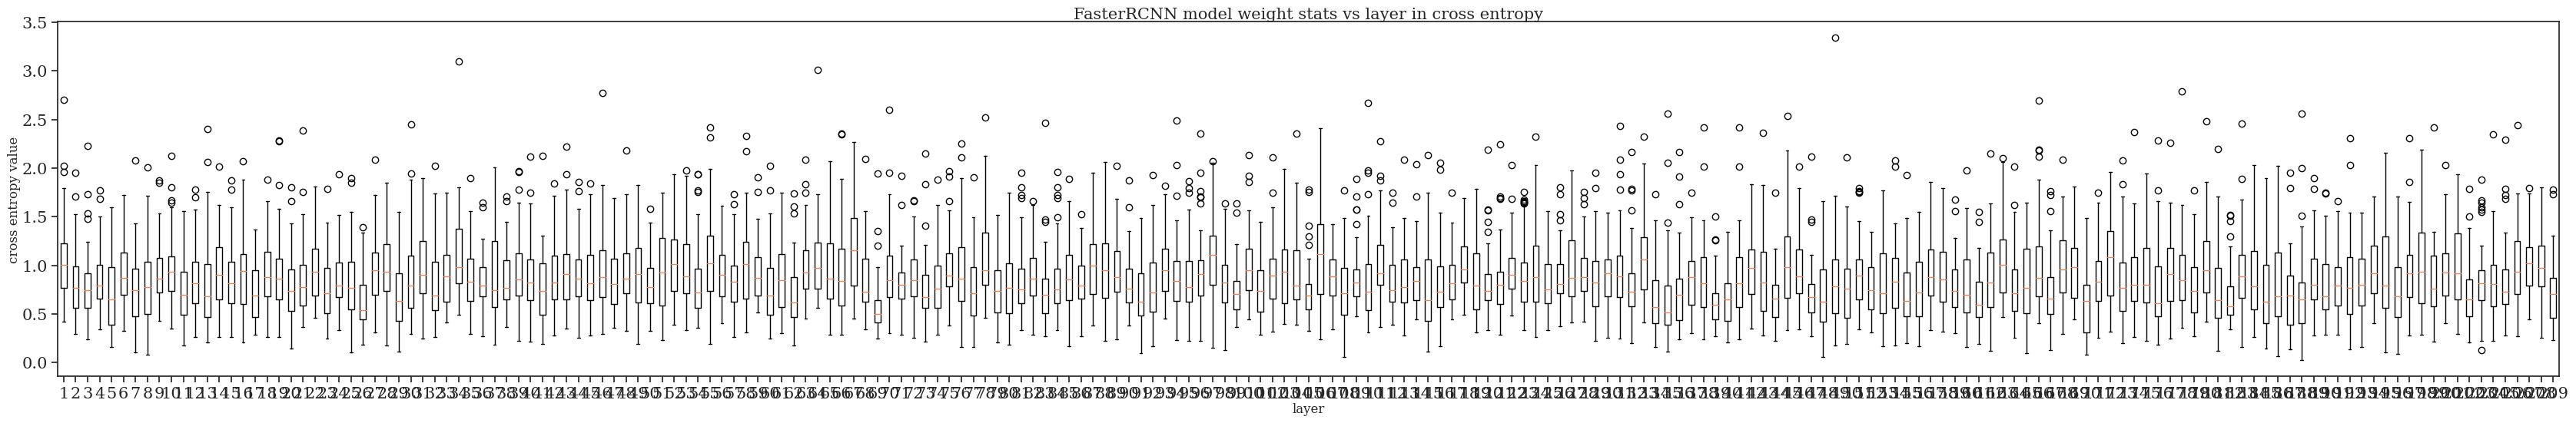

In [37]:
fig, ax = plt.subplots(figsize=(42, 6))
plt.boxplot(cens);
ax.set_title(f'{key} model weight stats vs layer in cross entropy');
ax.set_xlabel('layer');
ax.set_ylabel('cross entropy value');

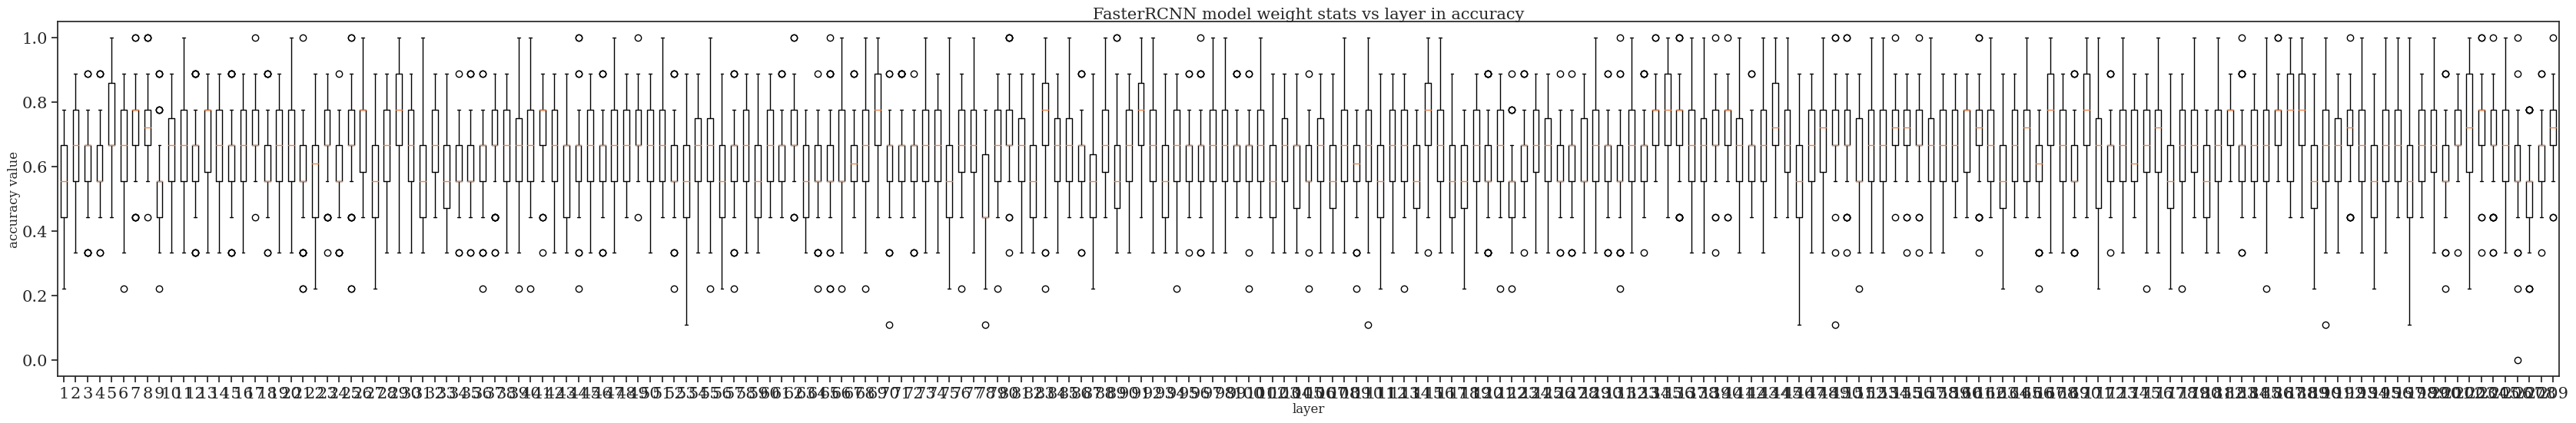

In [38]:
fig, ax = plt.subplots(figsize=(42, 6))
plt.boxplot(accs);
ax.set_title(f'{key} model weight stats vs layer in accuracy');
ax.set_xlabel('layer');
ax.set_ylabel('accuracy value');

In [34]:
mean_cens, mean_accs = np.mean(cens, axis=-1), np.mean(accs, axis=-1)

In [39]:
np.argsort(mean_cens)[:20], np.argsort(mean_accs)[::-1][:20]

(array([ 68, 138, 169,  25, 133, 134, 160, 139, 143, 181, 187,  61, 184,
         28, 166, 147, 201, 154, 146,   4]),
 array([187, 169, 166,  28, 185, 134,  90, 133, 139, 181,  68, 114, 153,
        143,   6,   7,   4, 186, 135, 202]))

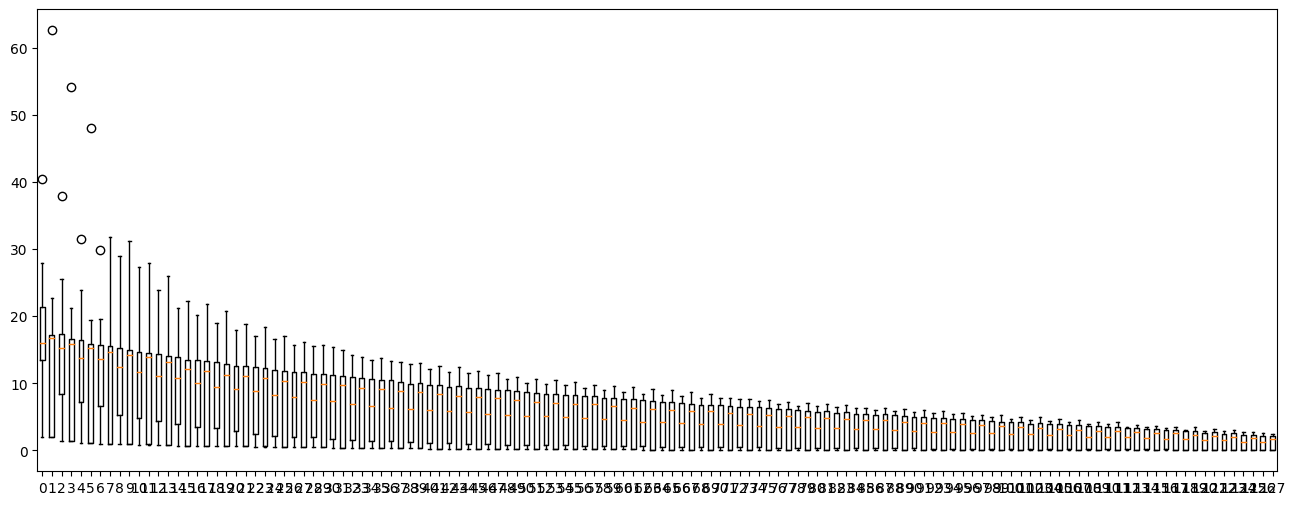

In [45]:
fig, axs = plt.subplots(figsize=(16, 6))
plt_X, plt_y = np.asarray(X[key]), np.asarray(y[key])
arr_poisoned = np.asarray(plt_X)[plt_y, eigen_len_range[0]:eigen_len_range[1]]
arr_clean = np.asarray(plt_X)[np.logical_not(plt_y), eigen_len_range[0]:eigen_len_range[1]]
ncol = arr_poisoned.shape[-1]*2
bar1 = axs.boxplot(arr_poisoned, positions=range(0, ncol, 2))
bar2 = axs.boxplot(arr_clean, positions=range(1, ncol, 2))

In [20]:
gb_df = METADATA.groupby(['model_architecture', 'poisoned', 'source_dataset_background_level']).apply(lambda x: x.index.tolist())

In [10]:
gb_df

model_architecture                           poisoned  source_dataset_background_level
object_detection:detr                        False     0                                         [9, 23, 30, 37, 40, 45, 58, 65]
                                                       1                                          [1, 5, 10, 17, 20, 25, 39, 41]
                                             True      0                                     [60, 64, 67, 68, 73, 100, 107, 109]
                                                       1                                             [2, 31, 46, 76, 77, 97, 99]
object_detection:fasterrcnn_resnet50_fpn_v2  False     0                                         [3, 14, 26, 38, 48, 50, 52, 59]
                                                       1                                         [8, 13, 18, 22, 55, 56, 57, 63]
                                                       2                                       [78, 80, 85, 86, 87, 88, 89, 104]
          

In [7]:
X = np.asarray(X)

In [8]:
X.shape

(117, 10)

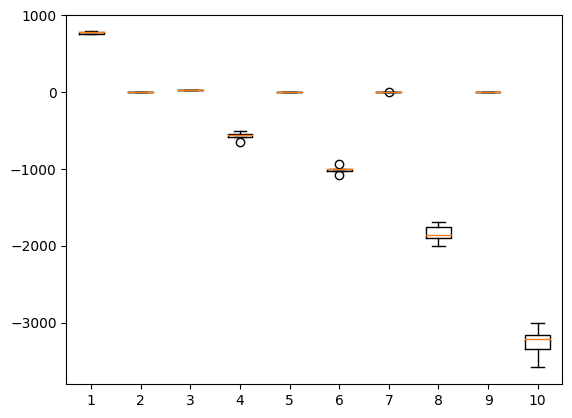

In [18]:
plt.boxplot(X[[81, 83, 92, 93, 102]]);

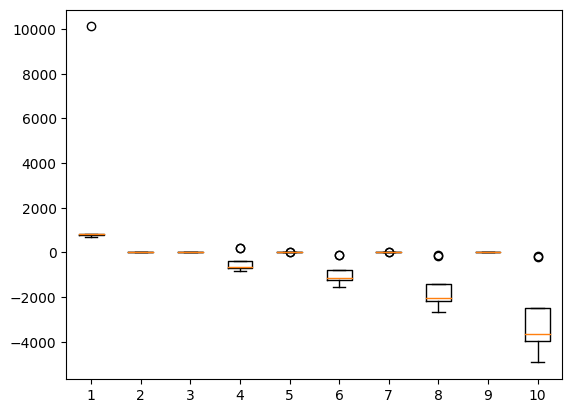

In [19]:
plt.boxplot(X[[82, 84, 90, 101, 110, 111, 112, 114]]);

In [129]:
dota_clean_inds, dota_poisoned_inds = [78, 80, 85, 86, 87, 88, 89, 104], [94, 96, 103, 105, 106, 108, 113, 116]

In [68]:
ssd_inds = METADATA[METADATA['model_architecture'] == 'object_detection:ssd300_vgg16'].index.tolist()

In [71]:
ssd_inds_dict = {ssd_ind:i for i, ssd_ind in enumerate(ssd_inds)}

In [111]:
inds_in_meta = [[0, 6, 15, 28, 34, 53, 54, 62], [4, 16, 19, 27, 29, 36, 42, 47], [81, 83, 92, 93, 102]]

In [114]:
inds_in_meta = [[12, 24, 35, 51, 66, 72, 79], [7, 33, 43, 44, 69, 71, 74], [82, 84, 90, 101, 110, 111, 112, 114]]

In [115]:
inds_in_dict = []
for ind_in_meta in inds_in_meta:
    inds = []
    for ind in ind_in_meta:
        inds.append(ssd_inds_dict[ind])
    inds_in_dict.append(inds)

In [116]:
inds_in_dict

[[4, 8, 14, 20, 24, 27, 29],
 [3, 12, 17, 18, 25, 26, 28],
 [31, 33, 34, 37, 39, 40, 41, 42]]

In [107]:
[np.asarray(X['SSD'])[ind, 0] for ind in inds_in_dict]

[array([10156.62988281,  8371.1875    ,  9969.95898438,  8884.6484375 ,
        10241.30078125, 10241.93554688,  9968.29980469, 10243.484375  ]),
 array([10238.21289062, 10088.7109375 , 10189.52148438,  8955.75878906,
        10134.84765625, 10182.10742188, 10159.19335938,  9945.43554688]),
 array([789.59118652, 751.5065918 , 783.93450928, 787.22296143,
        756.22912598])]

In [117]:
clean_dota_ssd_inds, trojan_dota_ssd_inds = [30, 32, 35, 36, 38], [31, 33, 34, 37, 39, 40, 41, 42]

In [110]:
[np.asarray(X['SSD'])[ind, 0] for ind in inds_in_dict]

[array([10224.11328125, 10235.2421875 , 10235.2421875 , 10198.91015625,
        10238.47070312, 10239.41992188,  9379.25976562]),
 array([10223.08398438, 10177.31542969, 10168.55664062, 10235.5625    ,
        10158.35351562, 10243.61328125, 10030.24414062]),
 array([  804.14453125,   802.05236816,   833.09521484,   833.09033203,
        10116.71386719,   705.11669922,   706.66125488,   804.44543457])]

In [88]:
METADATA.iloc[110]['source_dataset_background']

'dota_v2'

In [81]:
inds_in_dict

[[4, 8, 14, 20, 24, 27, 29],
 [3, 12, 17, 18, 25, 26, 28],
 [31, 33, 34, 37, 39, 40, 41, 42]]

In [25]:
arr_poisoned = np.asarray(X['SSD'])[y['SSD']][:, :20]
arr_clean = np.asarray(X['SSD'])[np.logical_not(y['SSD'])][:, :20]

In [182]:
gb_df.index

MultiIndex([(                      'object_detection:detr', False, 0),
            (                      'object_detection:detr', False, 1),
            (                      'object_detection:detr',  True, 0),
            (                      'object_detection:detr',  True, 1),
            ('object_detection:fasterrcnn_resnet50_fpn_v2', False, 0),
            ('object_detection:fasterrcnn_resnet50_fpn_v2', False, 1),
            ('object_detection:fasterrcnn_resnet50_fpn_v2', False, 2),
            ('object_detection:fasterrcnn_resnet50_fpn_v2',  True, 0),
            ('object_detection:fasterrcnn_resnet50_fpn_v2',  True, 1),
            ('object_detection:fasterrcnn_resnet50_fpn_v2',  True, 2),
            (              'object_detection:ssd300_vgg16', False, 0),
            (              'object_detection:ssd300_vgg16', False, 1),
            (              'object_detection:ssd300_vgg16', False, 2),
            (              'object_detection:ssd300_vgg16',  True, 0),
      

In [27]:
METADATA['source_dataset_background']

0      cityscapes
1            gta5
2            gta5
3      cityscapes
4            gta5
          ...    
112       dota_v2
113       dota_v2
114       dota_v2
115    cityscapes
116       dota_v2
Name: source_dataset_background, Length: 117, dtype: object

In [28]:
METADATA['source_dataset_background_level']

0      0
1      1
2      1
3      0
4      1
      ..
112    2
113    2
114    2
115    0
116    2
Name: source_dataset_background_level, Length: 117, dtype: int64

In [195]:
arr_poisoned = np.asarray([X[ind] for ind in gb_df.loc['object_detection:fasterrcnn_resnet50_fpn_v2'][True][1]])[:, -20:]
arr_clean = np.asarray([X[ind] for ind in gb_df.loc['object_detection:fasterrcnn_resnet50_fpn_v2'][False][1]])[:, -20:]

In [ ]:
fig, axs = plt.subplots(figsize=(16, 18), nrows=3)
for row in range(3):
    arr_poisoned = np.asarray([X[ind] for ind in gb_df.loc['object_detection:fasterrcnn_resnet50_fpn_v2'][True][row]])[:, :]
    arr_clean = np.asarray([X[ind] for ind in gb_df.loc['object_detection:fasterrcnn_resnet50_fpn_v2'][False][row]])[:, :]
    ncol = arr_poisoned.shape[-1]*2
    bar1 = axs[row].boxplot(arr_poisoned, positions=range(0, ncol, 2), c='g')
    bar2 = axs[row].boxplot(arr_clean, positions=range(1, ncol, 2), c='b')
# plt.suptitle('Comparison of Round_10 and Current Round with Eigen Value Analysis Pipeline')
# fig.tight_layout()
plt.show()

0                                         [3, 14, 26, 38, 48, 50, 52, 59]
                                                       1                                         [8, 13, 18, 22, 55, 56, 57, 63]
                                                       2                                       [78, 80, 85, 86, 87, 88, 89, 104]
                                             True      0                                               [21, 32, 49, 75, 98, 115]
                                                       1                                                    [11, 61, 70, 91, 95]
                                                       2                                  [94, 96, 103, 105, 106, 108, 113, 116]

(500.0, 1000.0)

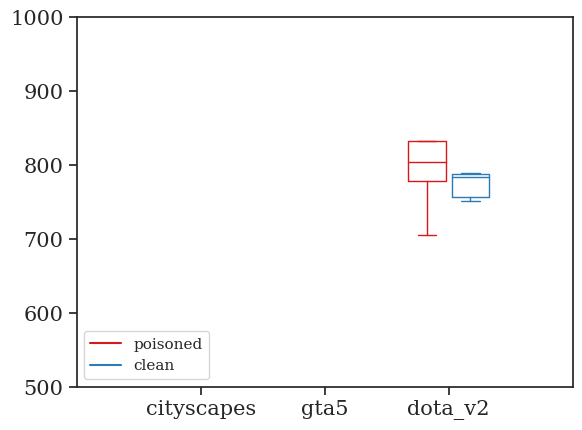

In [46]:
ticks = [0, 1, 2]
 
# create a boxplot for two arrays separately,
# the position specifies the location of the
# particular box in the graph,
# this can be changed as per your wish. Use width
# to specify the width of the plot
p = [[12, 24, 35, 51, 66, 72, 79], [7, 33, 43, 44, 69, 71, 74], [82, 84, 90, 101, 110, 111, 112, 114]]
c = [[0, 6, 15, 28, 34, 53, 54, 62], [4, 16, 19, 27, 29, 36, 42, 47], [81, 83, 92, 93, 102]]
poisoned_plot = plt.boxplot([X[p[t], 0] for t in ticks],
                               positions=np.array(np.arange(3))*2.0-0.35,
                               widths=0.6)
clean_plot = plt.boxplot([X[c[t], 0] for t in ticks],
                               positions=np.array(np.arange(3))*2.0+0.35,
                               widths=0.6)
 
# each plot returns a dictionary, use plt.setp()
# function to assign the color code
# for all properties of the box plot of particular group
# use the below function to set color for particular group,
# by iterating over all properties of the box plot
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend(loc=3)
 
 
# setting colors for each groups
define_box_properties(poisoned_plot, '#D7191C', 'poisoned')
define_box_properties(clean_plot, '#2C7BB6', 'clean')
 
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ['cityscapes', 'gta5', 'dota_v2'])
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)
 
# set the limit for y axis
plt.ylim(500, 1000)
 
# set the title
# plt.title('First Layer Weight Summation of SSD Model on Dataset background')

load = model size / number of data

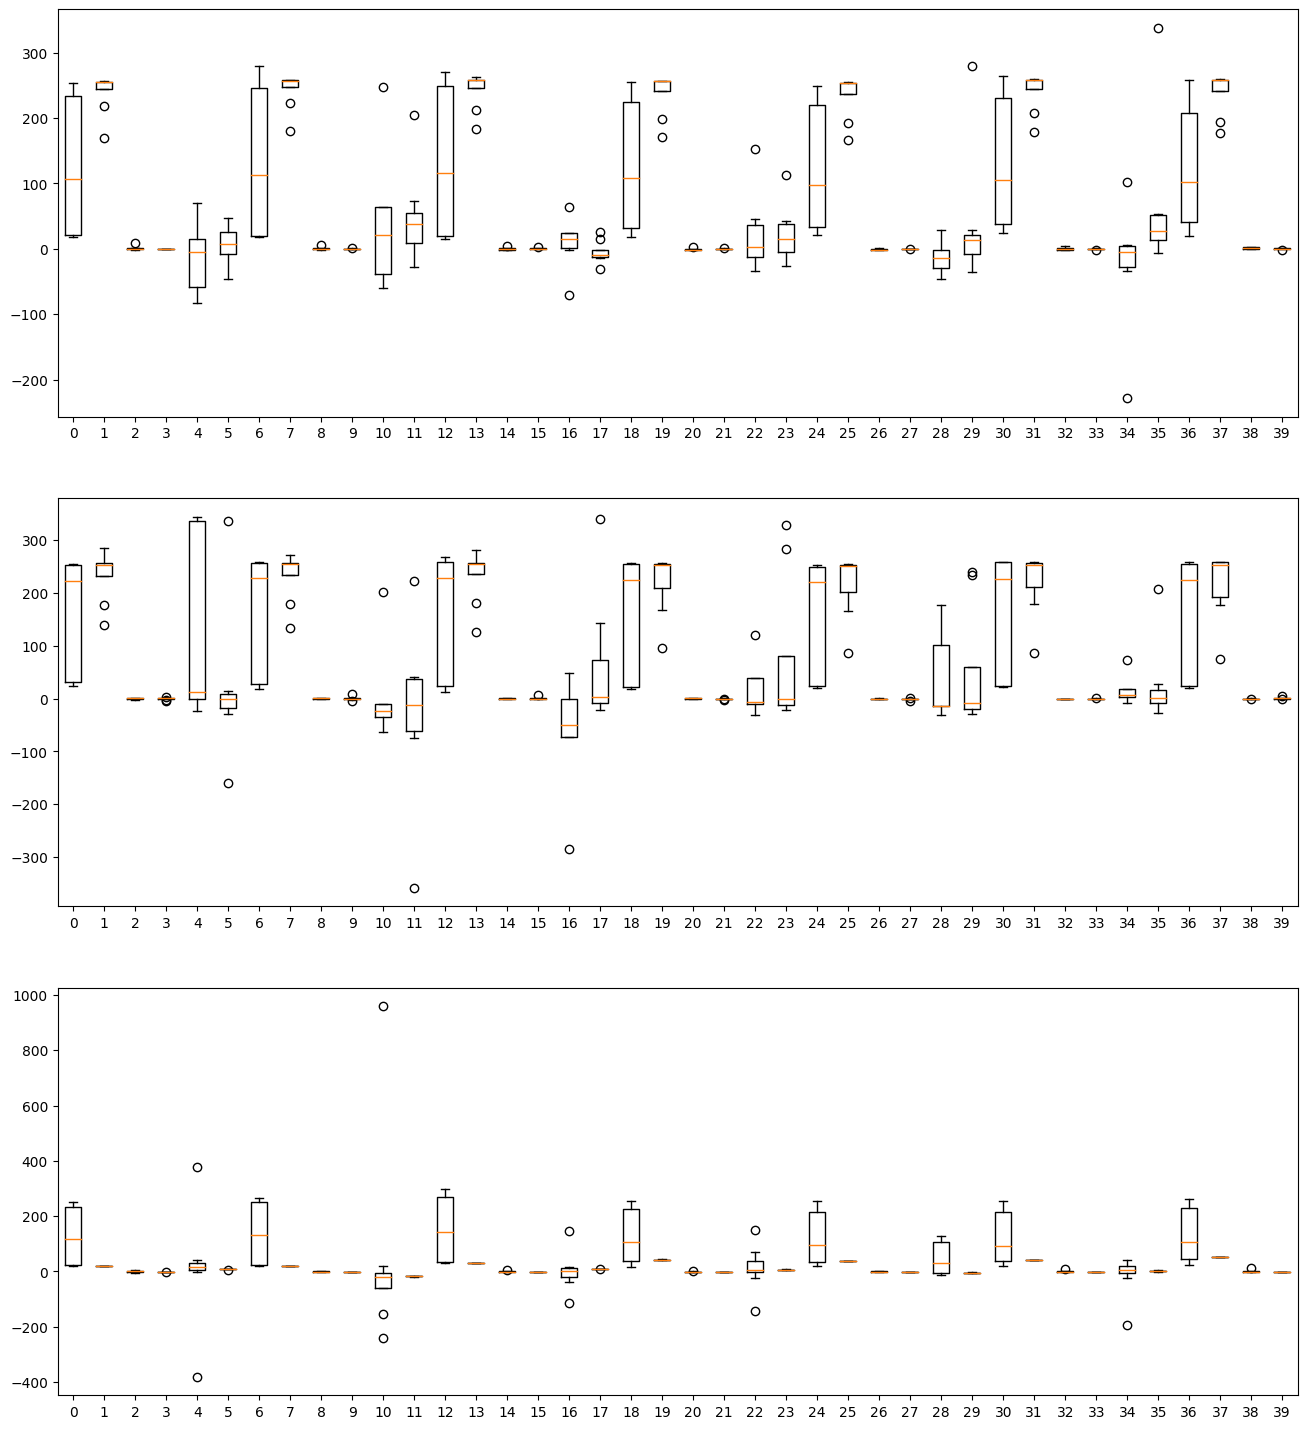

In [12]:
fig, axs = plt.subplots(figsize=(16, 18), nrows=3)
for row in range(3):
    arr_poisoned = np.asarray([X[ind] for ind in gb_df.loc['object_detection:fasterrcnn_resnet50_fpn_v2'][True][row]])[:, -20:]
    arr_clean = np.asarray([X[ind] for ind in gb_df.loc['object_detection:fasterrcnn_resnet50_fpn_v2'][False][row]])[:, -20:]
    ncol = arr_poisoned.shape[-1]*2
    bar1 = axs[row].boxplot(arr_poisoned, positions=range(0, ncol, 2))
    bar2 = axs[row].boxplot(arr_clean, positions=range(1, ncol, 2))
# plt.suptitle('Comparison of Round_10 and Current Round with Eigen Value Analysis Pipeline')
# fig.tight_layout()
plt.show()

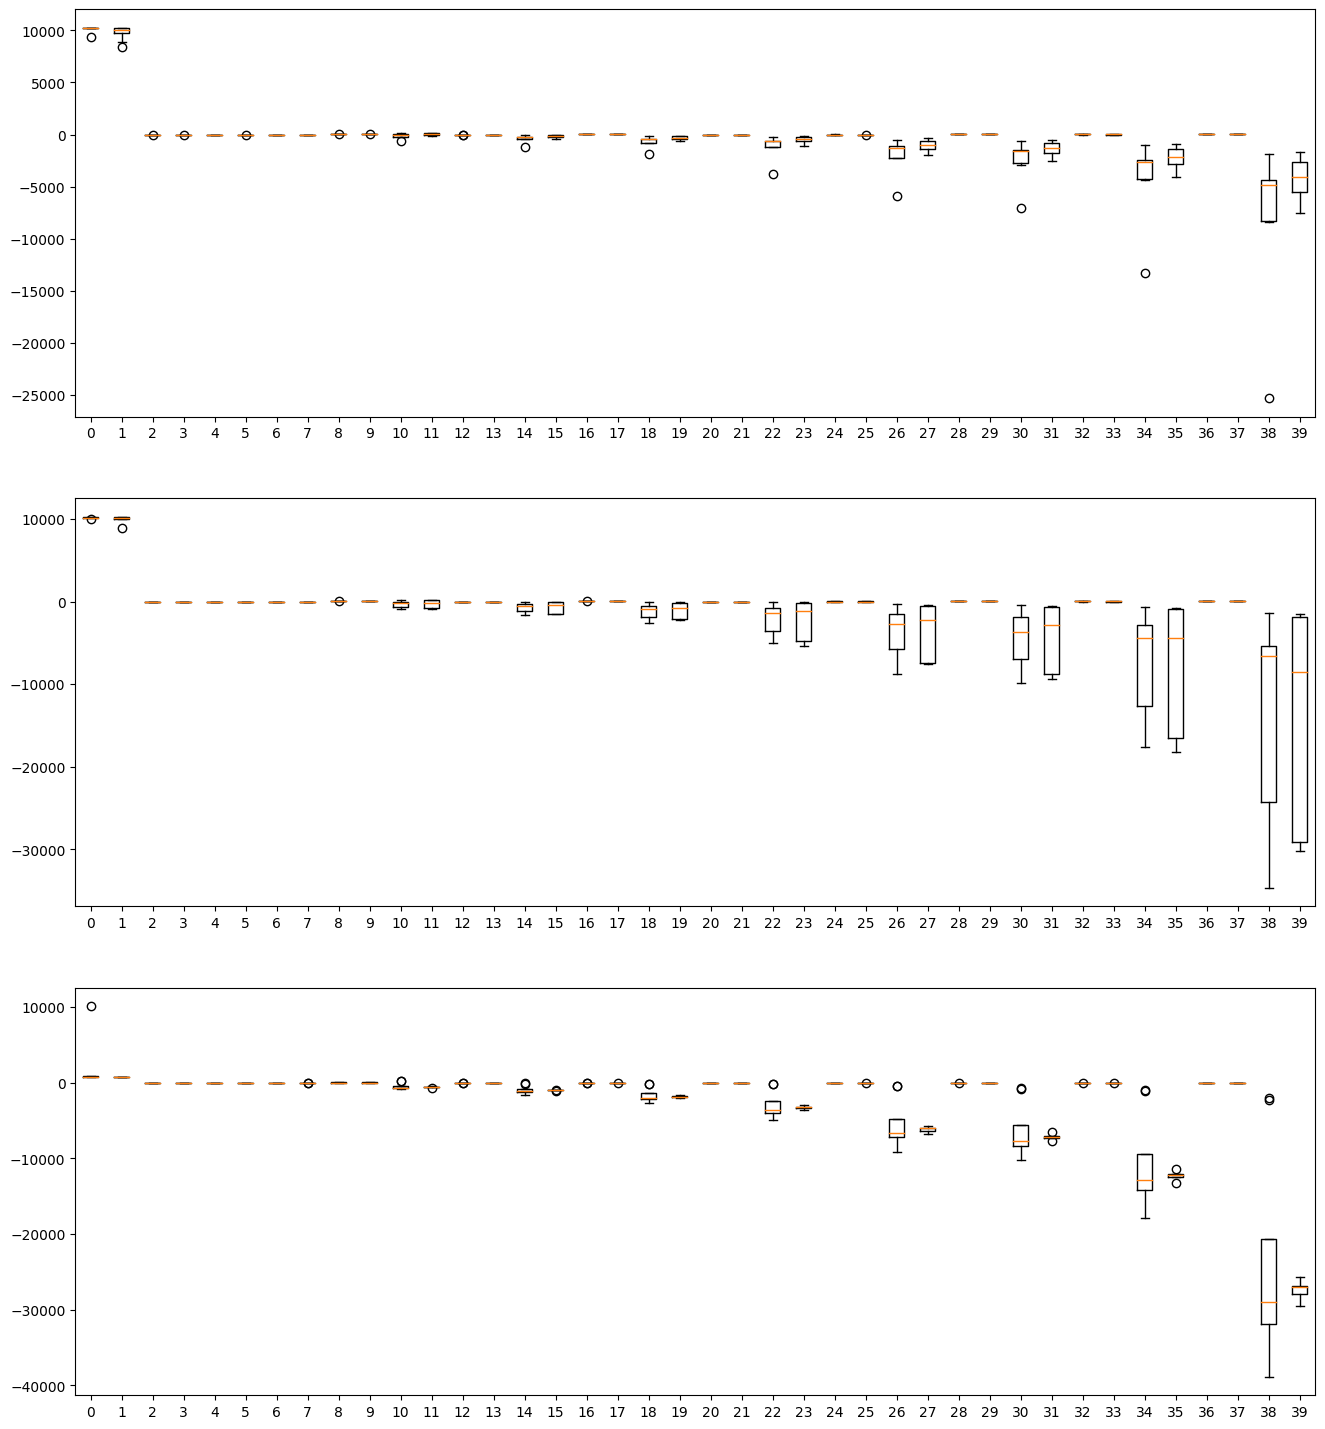

In [14]:
fig, axs = plt.subplots(figsize=(16, 18), nrows=3)
for row in range(3):
    arr_poisoned = np.asarray([X[ind] for ind in gb_df.loc['object_detection:ssd300_vgg16'][True][row]])[:, :20]
    arr_clean = np.asarray([X[ind] for ind in gb_df.loc['object_detection:ssd300_vgg16'][False][row]])[:, :20]
    ncol = arr_poisoned.shape[-1]*2
    bar1 = axs[row].boxplot(arr_poisoned, positions=range(0, ncol, 2))
    bar2 = axs[row].boxplot(arr_clean, positions=range(1, ncol, 2))
plt.show()

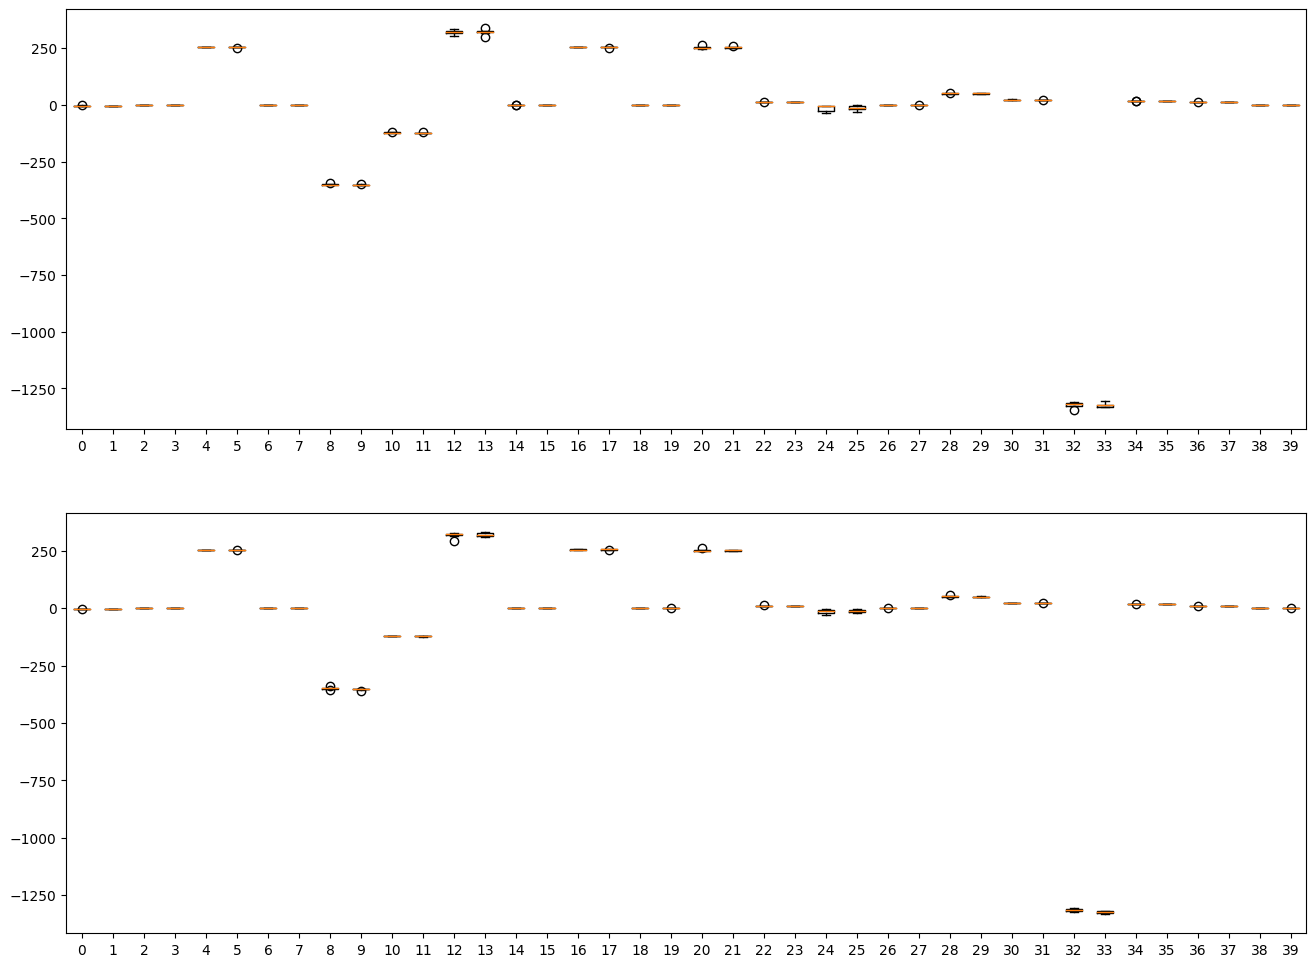

In [16]:
fig, axs = plt.subplots(figsize=(16, 12), nrows=2)
for row in range(2):
    arr_poisoned = np.asarray([X[ind] for ind in gb_df.loc['object_detection:detr'][True][row]])[:, -20:]
    arr_clean = np.asarray([X[ind] for ind in gb_df.loc['object_detection:detr'][False][row]])[:, -20:]
    ncol = arr_poisoned.shape[-1]*2
    bar1 = axs[row].boxplot(arr_poisoned, positions=range(0, ncol, 2))
    bar2 = axs[row].boxplot(arr_clean, positions=range(1, ncol, 2))
plt.show()

# Visualization

In [9]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        # clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps, labels=[0, 1]))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [10]:
clf_dict = {'FasterRCNN':  GradientBoostingClassifier(n_estimators=1100, learning_rate=0.00225, max_depth=8, min_samples_split=17, subsample=.66, min_samples_leaf=4, max_features=230), 
            'SSD': GradientBoostingClassifier(n_estimators=900, learning_rate=0.003, max_depth=4, min_samples_split=11, subsample=.63, max_features=240),
            'DetrForObjectDetection': GradientBoostingClassifier(n_estimators=1300, learning_rate=.019, max_depth= 4, max_features= 24, min_samples_leaf= 12, min_samples_split= 20)}

In [12]:
clf_dict = {'FasterRCNN': GradientBoostingClassifier(n_estimators=2350, learning_rate=0.256, max_depth=4, min_samples_split=20, subsample=.54, min_samples_leaf=65, max_features=400), 
            'SSD': GradientBoostingClassifier(n_estimators=225, learning_rate=0.007, max_depth=2, min_samples_leaf=6, min_samples_split=16, max_features=300, subsample=.6),
            'DetrForObjectDetection': GradientBoostingClassifier(n_estimators=1100, learning_rate=.196, max_depth= 4, max_features= 400, min_samples_leaf= 45, min_samples_split= 60, subsample=.62)}

In [13]:
for k, v in clf_dict.items():
    X, y = np.load(os.path.join('/scratch/jialin/object-detection-feb2023/weight_analysis/extracted_source/eigen.4_wstats_subsample', f'{k}_X.npy')), np.load(os.path.join('/scratch/jialin/object-detection-feb2023/weight_analysis/extracted_source/eigen.4_wstats_subsample', f'{k}_y.npy'))
    cen, acc = bootstrap_performance(X, y, v, n=50, test_size=.2)
    print(k, np.mean(cen), np.mean(acc))

FasterRCNN 0.708880018690028 0.5177777777777778
SSD 0.7251499792619934 0.3866666666666667
DetrForObjectDetection 0.8511710159300294 0.7342857142857142


In [14]:
for k, v in clf_dict.items():
    X, y = np.load(os.path.join(OUTPUT_FILEDIR, f'{k}_X.npy')), np.load(os.path.join(OUTPUT_FILEDIR, f'{k}_y.npy'))
    clf = v.fit(X, y)
    joblib.dump(clf, os.path.join(OUTPUT_FILEDIR, f'{k}_clf.joblib'))

In [11]:
for k, v in X.items():
    clf = clf_dict[k]
    cen, acc = bootstrap_performance(v, y[k], clf, n=50, test_size=.2)
    print(k, np.mean(cen), np.mean(acc))
    # print(np.argsort(cen)[:10], np.asarray(cen)[np.argsort(cen)[:10]])
    # print(np.argsort(acc)[::-1][:10], np.asarray(acc)[np.argsort(acc)[::-1][:10]])

SSD 0.6350781540864998 0.7266666666666669
DetrForObjectDetection 0.7502614615266917 0.5457142857142856
FasterRCNN 0.6174911918613717 0.7088888888888889


eigen(.5) + weight:
SSD 0.5742148777722668 0.6933333333333332
DetrForObjectDetection 0.7076452540546534 0.6571428571428573
FasterRCNN 0.6123584841137905 0.7244444444444443
weight:
SSD 0.6460716948869945 0.691111111111111
DetrForObjectDetection 0.5440759932804827 0.7414285714285715
FasterRCNN 0.6230866976861928 0.7244444444444443
normalized weight:
SSD 0.7054846389790674 0.6844444444444444
DetrForObjectDetection 0.6811323027339867 0.64
FasterRCNN 0.6923057213981706 0.6799999999999998
eigen(.4) + weight:
SSD 0.5812029632266128 0.6866666666666665
DetrForObjectDetection 0.5909579794119415 0.7028571428571427
FasterRCNN 0.6121626781217447 0.7266666666666666

eigen val from layers
SSD 0.6467230935677822 0.7066666666666666
DetrForObjectDetection 0.7494677783113759 0.5342857142857141
FasterRCNN 0.6547701197345001 0.7288888888888888

In [21]:
for k, v in X.items():
    clf = clf_dict[k].fit(v, y[k])
    joblib.dump(clf, os.path.join(OUTPUT_FILEDIR, f'{k}_clf.joblib'))

In [18]:
X.keys()

dict_keys(['SSD', 'DetrForObjectDetection', 'FasterRCNN'])

In [4]:
k = 'SSD'

In [5]:
X = np.load(os.path.join(OUTPUT_FILEDIR, f'{k}_X.npy'))
y = np.load(os.path.join(OUTPUT_FILEDIR, f'{k}_y.npy'))

In [6]:
X.shape

(43, 1063)

In [10]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.111, max_depth=2, min_samples_leaf=6, min_samples_split=16, subsample=.6, max_features=300)
# param={'max_depth': range(2, 9, 2), 'min_samples_leaf': range(2, 35, 4), 'min_samples_split': range(16, 65, 4), 'max_features': range(200, 411, 20), 'subsample': np.arange(.6, .91, .02)}
# param = {'learning_rate':np.arange(.05, .301, .05), 'n_estimators':range(100, 2001, 25)}
param = {'learning_rate':np.arange(.001, .301, .001), 'n_estimators':range(100, 3001, 25)}
# param = {'learning_rate':[.015, .03, .005, .01, .0025, .025, .003, .0015, .0005], 'n_estimators':[125, 63, 375, 187, 750, 75, 630, 1250, 3750]}
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X, y);

In [11]:
gsearch_result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss', 'rank_test_accuracy'])
gsearch_result.to_csv(os.path.join(OUTPUT_FILEDIR, f'gsearch_result_{k}.csv'))

In [12]:
gsearch_result.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,...,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3745,0.078553,0.000611,0.001505,0.000028,0.033,125,"{'learning_rate': 0.033, 'n_estimators': 125}",-0.341112,-0.549322,-0.706908,...,0.140328,1,0.888889,0.777778,0.444444,0.750,0.250,0.622222,0.237398,32209
8073,0.063099,0.001126,0.001582,0.000049,0.07,100,"{'learning_rate': 0.07, 'n_estimators': 100}",-0.356271,-0.657309,-0.693475,...,0.131424,2,0.888889,0.666667,0.666667,0.750,0.250,0.644444,0.213293,27848
12870,0.071993,0.008178,0.001946,0.000462,0.111,100,"{'learning_rate': 0.111, 'n_estimators': 100}",-0.228063,-0.557090,-0.718041,...,0.212997,3,0.888889,0.666667,0.666667,0.750,0.625,0.719444,0.093953,2464
5850,0.062990,0.000678,0.001561,0.000037,0.051,100,"{'learning_rate': 0.051000000000000004, 'n_est...",-0.352012,-0.573338,-0.721012,...,0.142894,4,0.888889,0.777778,0.666667,0.625,0.375,0.666667,0.172357,20042
5968,0.079375,0.001292,0.001526,0.000033,0.052,125,"{'learning_rate': 0.052000000000000005, 'n_est...",-0.273112,-0.569925,-0.681151,...,0.193816,5,0.888889,0.666667,0.666667,0.750,0.250,0.644444,0.213293,27848
7839,0.063560,0.001277,0.001533,0.000042,0.068,100,"{'learning_rate': 0.068, 'n_estimators': 100}",-0.273675,-0.567905,-0.705889,...,0.190345,6,1.000000,0.666667,0.666667,0.750,0.375,0.691667,0.200000,9553
3042,0.062784,0.000799,0.001521,0.000027,0.027,100,"{'learning_rate': 0.027000000000000003, 'n_est...",-0.462242,-0.584624,-0.601283,...,0.103198,7,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042
3393,0.062645,0.000817,0.001481,0.000028,0.03,100,"{'learning_rate': 0.030000000000000002, 'n_est...",-0.405477,-0.606294,-0.640579,...,0.122382,8,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042
4565,0.094876,0.001898,0.001575,0.000037,0.04,150,"{'learning_rate': 0.04, 'n_estimators': 150}",-0.285554,-0.617364,-0.692358,...,0.186864,9,1.000000,0.555556,0.666667,0.750,0.375,0.669444,0.207573,19652
1291,0.125181,0.002050,0.001607,0.000009,0.012,200,"{'learning_rate': 0.012, 'n_estimators': 200}",-0.468924,-0.609551,-0.642298,...,0.088974,10,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042


In [13]:
gsearch_result['mean_test_accuracy']

3745     0.622222
8073     0.644444
12870    0.719444
5850     0.666667
5968     0.644444
           ...   
29586    0.619444
33249    0.650000
34539    0.700000
34500    0.630556
34179    0.652778
Name: mean_test_accuracy, Length: 35100, dtype: float64

In [14]:
gsearch_result['rank_test_accuracy']

3745     32209
8073     27848
12870     2464
5850     20042
5968     27848
         ...  
29586    32524
33249    24445
34539     3014
34500    28522
34179    21022
Name: rank_test_accuracy, Length: 35100, dtype: int32

In [15]:
gsearch_result['mean_test_neg_log_loss']

3745    -0.596133
8073    -0.608179
12870   -0.611247
5850    -0.614984
5968    -0.619903
           ...   
29586   -3.528528
33249   -3.534978
34539   -3.559429
34500   -3.560073
34179   -3.623068
Name: mean_test_neg_log_loss, Length: 35100, dtype: float64